In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
original_dataset = pd.read_csv('data.csv')
original_dataset.describe()

,Seller,Buyer,Amt
count,708466.000000,708466.000000,7.084660e+05
mean,9495.510809,10689.271725,4.446489e+04
std,8593.744882,9125.190479,9.083406e+04
min,9.000000,1.000000,0.000000e+00
25%,2548.000000,2783.000000,1.006350e+04
50%,6814.000000,7880.000000,2.853200e+04
75%,14907.000000,17104.000000,6.294830e+04
max,32444.000000,32449.000000,5.030950e+07


### Preprocessing

**Drop transactions with value 0**

In [3]:
dataset = original_dataset.drop(original_dataset[original_dataset['Amt'] == 0].index)
dataset.describe()

,Seller,Buyer,Amt
count,707549.000000,707549.000000,7.075490e+05
mean,9501.940555,10696.489437,4.452252e+04
std,8594.180764,9126.080854,9.087879e+04
min,9.000000,1.000000,1.000000e-01
25%,2548.000000,2822.000000,1.010325e+04
50%,6814.000000,7883.000000,2.859330e+04
75%,14907.000000,17139.000000,6.301865e+04
max,32444.000000,32449.000000,5.030950e+07


**Drop self edges**

In [4]:
dataset = dataset.drop(dataset[dataset['Seller'] == dataset['Buyer']].index)
dataset.describe()

,Seller,Buyer,Amt
count,665442.000000,665442.000000,6.654420e+05
mean,9940.664065,11210.800106,4.453210e+04
std,8642.170418,9137.748270,6.633225e+04
min,9.000000,1.000000,1.000000e-01
25%,2782.000000,3182.000000,1.007746e+04
50%,7549.000000,8795.000000,2.878920e+04
75%,15315.000000,17948.000000,6.322500e+04
max,32444.000000,32449.000000,1.898131e+07


### Performing benford analysis on the overall transactions

In [5]:
from math import log10

def benford_analysis(vals):
    # Expected Benford frequencies
    expected_freq = [round(len(vals) * log10(1 + 1/d)) for d in range(1, 10)]

    # Convert to scientific notation and get first digit
    first_digit = lambda x: int(('%e' % x)[0])

    # Get observed first digit frequencies
    observed_freq = [0] * 10
    for val in vals:
        observed_freq[first_digit(val)] += 1
    observed_freq = observed_freq[1:]

    print('Expected frequencies: ', expected_freq)
    print('Observed frequencies: ', observed_freq)
    
    plt.plot(range(1, 10), expected_freq, label='Expected')
    plt.plot(range(1, 10), observed_freq, label='Observed')
    plt.legend(loc='upper right')
    plt.show()
    
    mean_abs_dev = 1/(len(vals)*9) * sum([abs(obv-exp)
                                          for obv, exp in zip(observed_freq, expected_freq)])
    print('Mean absolute deviation: %.6lf' % mean_abs_dev)

Expected frequencies:  [200318, 117179, 83139, 64488, 52691, 44549, 38590, 34039, 30449]
Observed frequencies:  [201751, 80134, 69050, 79204, 67115, 51811, 43240, 37782, 35355]


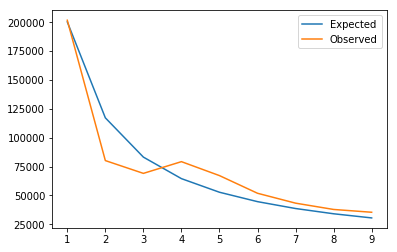

Mean absolute deviation: 0.017076


In [6]:
benford_analysis(dataset['Amt'])

$\text{Mean Absolute Deviation (MAD) is around 0.017 which implies a nonconformity between the expected probability and} \\ \text{the observed probability.}$

### Pruning the transaction graph

- We only consider the nodes (users) which have both incoming and outgoing edges.
- This is because our goal is to identify circular trading and nodes need to have both incoming and outgoing edges to be part of a cycle.

In [7]:
sellers = set(dataset['Seller'])
buyers = set(dataset['Buyer'])
seller_buyer_union = sellers.union(buyers)
seller_buyer_intersection = sellers.intersection(buyers)

print('Sellers:', len(sellers))
print('Buyers:', len(buyers))
print('Sellers Union Buyers:', len(seller_buyer_union))
print('Sellers Intersection Buyers:', len(seller_buyer_intersection))

Sellers: 8354
Buyers: 30400
Sellers Union Buyers: 32369
Sellers Intersection Buyers: 6385


In [8]:
import networkx as nx

In [9]:
G = nx.MultiDiGraph()

for seller, buyer, amt in dataset[['Seller', 'Buyer', 'Amt']].values:
    if (seller in seller_buyer_intersection
            and buyer in seller_buyer_intersection):
        G.add_weighted_edges_from([(int(seller), int(buyer), amt)])

In [10]:
len(G.nodes())

6279

$\text{Even though the total users who act as both buyers and sellers are 6385, we only have 6279 users in our truncated graph, this is because} \\ \text{we only add an edge when both the vertices are buyers and sellers} \\ \text{(Ex: Consider the case a->b->c where b is the only one who is both buying and selling but b won't be added to the updated transaction graph.}$

**Removing edges which satisfy certain conditions (like considering only those weights which fall in a certain range etc)**

In [40]:
def threshold_weights(G, should_consider_edge):
    edges = [
        (u, v, w['weight']) for u, v, w in G.edges(data=True)
        if should_consider_edge(w['weight'])
    ]
    
    X = nx.MultiDiGraph()
    X.add_weighted_edges_from(edges)
    return X

In [41]:
G = threshold_weights(G, )

In [42]:
len(G.edges())

452127

**Shared Nearest Neighbor Clustering (using Jarvis-Patrick Algorithm)**

In [29]:
def shared_nn_clustering(G, t=3):
    class UnionFind:
        def __init__(self, nodes):
            self.color = {
                node: node
                for node in nodes
            }
            
        def representative(self, i):
            if i != self.color[i]:
                self.color[i] = self.representative(self.color[i])
            return self.color[i]

        def union(self, i, j):
            p_i, p_j = self.representative(i), self.representative(j)
            if p_i != p_j:
                self.color[p_i] = p_j
        
        def is_connected(self, i, j):
            return self.representative(i) == self.representative(j)
    
    G = nx.Graph(G)
    neighbors = {
        n: set(G.neighbors(n))
        for n in G.nodes()
    }
    
    coloring = UnionFind(G.nodes())
    for u in G.nodes():
        for v in neighbors[u]:
            # If u, v share more than t neighbors then given them the same color
            shared_neighbors = neighbors[u].intersection(neighbors[v])
            if len(shared_neighbors) >= t:
                coloring.union(u, v)

    representatives = {
        node: coloring.representative(node)
        for node in G.nodes()
    }

    clusters = []
    for rep in set(representatives.values()):
        cluster = []
        for node, col in representatives.items():
            if col == rep:
                cluster.append(node)

        clusters.append(cluster)                

    return clusters

In [70]:
G_1 = threshold_weights(G, lambda w: True)
clusters = shared_nn_clustering(G_1, t=2)

In [71]:
len(clusters)

3043

In [73]:
for cluster in clusters:
    if 3 <= len(cluster) <= 10:
        for u, v in set(G.subgraph(cluster).edges()):
            print(u, v)
        print()

26471 29972
26471 13647
13647 29972
13647 15295
11112 15295
15295 13647
11112 26471
29972 11112
15295 29972

31676 12968
20960 12968
20960 31676
12968 31676



### Few cycles which have been detected after clustering stage 1

**Considering all edges**
<img src='clusters/1_graph.png'>
<img src='clusters/1_cycle.png'>

**Considering edges with weights in range [1000, 5000]**
<img src='clusters/2_cycle.png'>
<img src='clusters/3_cycle.png'>

**Considering edges with weights in range [1000, 10000]**
<img src='clusters/4_cycle.png'>
<img src='clusters/5_cycle.png'>